Copyright © 2025 Technical University of Denmark

# Comparing Fock state approximations

In [1]:
import numpy as np
from lcg_plus.base import State
from lcg_plus.states.coherent import order_infidelity_fock_coherent, gen_fock_coherent
from lcg_plus.states.wigner import wig_mn
from lcg_plus.states.from_sf import prepare_fock_log
from lcg_plus.fidelity import overlap_with_wigner
from lcg_plus.states.nongauss import prepare_fock_coherent
from lcg_plus.plotting import plot_wig

In [2]:
from os import chdir
chdir('../')

In [3]:
#Plotting stuff

import matplotlib as mpl
from matplotlib import pyplot as plt

colwidth = 3.41667
fs = 8
mpl.rcParams.update({'font.size': fs, 
                     "text.usetex":  True, 
                     'font.family':'serif',
                     'xtick.labelsize': 8, 
                     'ytick.labelsize':8 })

fig_kwargs = {'dpi':800, 'bbox_inches': 'tight'}

Superposition of coherent states for Fock 5
--------------------------------------------------
Magnitude of coherent states, eps = 0.5
Number of Gaussians = 21
Expected infidelity of approximation 7.339e-10
Numerical fidelity to analytical Fock 5, 1-F = 6.410e-10
Max coefficient = 4.4e+03

Linear combination of thermal states for Fock 5
--------------------------------------------------
Two mode squeezing in the approximation, r = 0.05, r<1/sqrt(n): True
Number of Gaussians = 6
Numerical fidelity to analytical Fock 5, 1-F = 3.651e-02
Max coefficient = 8.3e+11
State norm (0.9998160856169805+2.98111561244974e-08j)


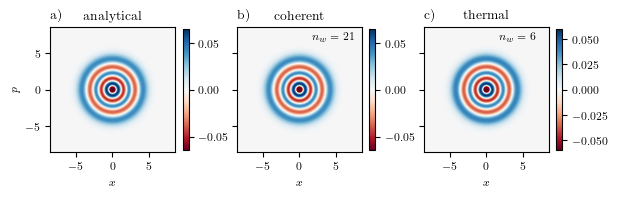

In [4]:
hbar=2
#Settings
N = 5
epsilon = 0.5
r = 0.05

x = np.sqrt(hbar)*np.linspace(-6,6,300)

X, P = np.meshgrid(x,x )
W_fock = wig_mn(N,N, X, P)

print(f'Superposition of coherent states for Fock {N}')
print('-'*50)

state = prepare_fock_coherent(N, 1, epsilon)
state.normalise()
infid = order_infidelity_fock_coherent(N, epsilon)
W = state.get_wigner_log(x,x)
log_weights = state.log_weights

fid = overlap_with_wigner(W_fock, W, x, x).real

print(f'Magnitude of coherent states, eps = {epsilon}')
print(f'Number of Gaussians = {len(log_weights)}')
print('Expected infidelity of approximation {:.3e}'.format(infid))
print('Numerical fidelity to analytical Fock {}, 1-F = {:.3e}'.format(N, 1 - fid))
print('Max coefficient = {:.1e}'.format(np.abs(np.max(np.exp(log_weights)))))

print(f'\nLinear combination of thermal states for Fock {N}')
print('-'*50)



th = prepare_fock_log(N, r = r)
W_th = th.get_wigner_log(x,x)
fid_th = overlap_with_wigner(W_fock, W_th, x, x).real

print(f'Two mode squeezing in the approximation, r = {r}, r<1/sqrt(n): {r < 1/np.sqrt(N)}')
print(f'Number of Gaussians = {len(th.weights)}')
print('Numerical fidelity to analytical Fock {}, 1-F = {:.3e}'.format(N,1 - fid_th))
print('Max coefficient = {:.1e}'.format(np.abs(np.max(th.weights))))
print(f'State norm {th.norm}')

fig, axes = plt.subplots(1,3, figsize = (2*colwidth, 0.56*colwidth), sharey=True, sharex=True )

plot_wig(W.real, x, x, ax = axes[1])
axes[1].set_title('b)', loc='left')
axes[1].set_title('coherent')
axes[1].set_ylabel('')
axes[1].text(0.6,0.9,rf'$n_w={len(state.log_weights)}$',transform=axes[1].transAxes)


plot_wig(W_fock.real, x ,x, ax = axes[0])
axes[0].set_title(f'a)', loc = 'left')
axes[0].set_title('analytical')

plot_wig(W_th.real, x, x, ax = axes[2])
axes[2].set_title('c)', loc = 'left')
axes[2].set_title('thermal')
axes[2].set_ylabel('')
axes[2].text(0.6,0.9,rf'$n_w={len(th.log_weights)}$',transform=axes[2].transAxes)

#plt.savefig(f'figspaper/linear_comb_gaussians/fock_{N}_wigners.pdf',**fig_kwargs)

plt.show()

## Fidelity of the Fock approximations
Here the fidelity of the Fock approximation from `strawberryfield`'s bosonic backend (using linear combinations of thermal states) and `lcg_plus` (using superpositions of coherent states) is compared. The fidelity is computed by performing the overlap integral $\int d^2{\xi} W_{\ket{n}\bra{n}}(\xi)\tilde{W}_{\ket{n}\bra{n}}(\xi)$ numerically. 

In [ ]:
fig, ax = plt.subplots(1, figsize = (colwidth,colwidth))
ax2=ax.twiny() #For the squeezing values
N = np.array([1, 3, 5, 10, 50])

colors = ['b','r','g','purple','c','k']

epsilons = 10**np.linspace(-2,1,20)
rs = 10**np.linspace(-3,-1,10)
##rs = np.array([1e-2, 2e-2, 4e-2, 6e-2,8e-2,1e-1, 2e-1, 4e-1]) 

x = np.sqrt(hbar)*np.linspace(-7,7,500)

for i, n in enumerate(N):

    infidelities = order_infidelity_fock_coherent(n, epsilons)

    #numerical infidelity
    X,P = np.meshgrid(x,x) #Has to be inside the loop for some reason
    W_fock = wig_mn(n,n,X,P)
    
    fidelities = np.zeros(len(epsilons))
    for j, eps in enumerate(epsilons):
        
        state = prepare_fock_coherent(n, 1, eps)
        state.normalise()
        W_coherent = state.get_wigner_log(x,x)
        
        fid = overlap_with_wigner(W_fock, W_coherent, x, x).real
        
        ax.loglog(eps, 1-fid, '.', color = colors[i] )
        
    ax.loglog(epsilons, infidelities, color = colors[i], label = rf'$n={n}$')

    
    
    for j, r in enumerate(rs):
        if 1/r**2 > n: #ensure physical state
            th = prepare_fock_log(n, r = r)
            W_th = th.get_wigner_log(x,x)

            fid = overlap_with_wigner(W_fock, W_th, x, x).real
            
            if j != len(rs) -1:
                ax2.loglog(r, 1-fid, 'x', color = colors[i])
            else:
                ax2.loglog(r, 1-fid, 'x', color = colors[i])
            
th = mpl.lines.Line2D([], [], color='gray', marker='x', linestyle='None',label ='thermal')
coh = mpl.lines.Line2D([], [], color='gray', marker='.', linestyle='None',label ='coherent')

ax.set_xlabel(r'Radius of the circle $|\alpha|$')
ax2.set_xlabel(r'Two mode squeezing strength $r$')
#axes.set_ylabel(r'$\mathcal{O}(1-\mathcal{F}(\left|N\right>,\left|\tilde{N}\right>))$')
ax.set_ylabel(r'Infidelity, $1-\mathcal{F}$')
ax.set_ylim([1e-12,1e-0+0.5])
#axes.set_xlim([1e-2,4e-1])
l1 = ax.legend(handles = [th, coh], loc = "lower right")
ax.legend(loc = "lower left")
ax.add_artist(l1)
ax.grid('on')
ax.set_title(r'Fidelity of approximations to $|n\rangle \langle n|$')

#plt.savefig('figspaper/linear_comb_gaussians/fock_approx_fidelity.pdf', **fig_kwargs)
plt.show()

/Users/s163967/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Git_Repos/bosonicplus/src/lcg_plus/states/coherent.py:108: RuntimeWarning: invalid value encountered in log
  log_weights -= np.log(norm)


## psuedo PNRD as an approximation to PNRD
The PNRD POVM $\hat{\Pi}_n=\ket{n}\bra{n}$, which is approximated by a linear combination of Gaussians (thermal states) in strawberryfields, can also be approximated by the pseudo PNRD POVM $\hat{\Pi}_k=\dots$, which is also a linear combination of Gaussians. Interestingly, the pPNRD approximation is nearly equivalent to the bosonic backend approximation for PNRD (with default value `r=0.05`) when the number of on/off detectors is `M=399`. 

In [ ]:
from lcg_plus.operations.measurements import ppnrd_povm_thermal

In [ ]:
#Compare PPNRD data with fock from bosonic backend data
n = 4
ppnrd_data = ppnrd_povm_thermal(n, 399)
fock = prepare_fock_log(n)


print(f'Covs from fock: \n{fock.covs}')
print(f'\nCovs from ppnrd: \n{ppnrd_data[1]}')

print(f'log-weights from fock: {fock.log_weights}')
print(f'\n log-Weights from ppnrd: {ppnrd_data[2]}')

In [ ]:
order_infidelity_fock_coherent(80, 10)